<a href="https://colab.research.google.com/github/sh-0620/solar/blob/main/Solar__panel_classification_EfficientNetB0_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm

In [4]:
#데이터 로드


In [5]:
# 하이퍼파라미터 설정
hyper_params = {
    'num_epochs': 30,  # 에포크 수 증가
    'lr': 0.001,
    'image_size': 224,
    'train_batch_size': 16,
    'val_batch_size': 8,
    'num_classes': 6,  # 클래스 수 설정
    'val_ratio': 0.2  # 검증 데이터 비율
}

In [6]:
# 1. 데이터 변환 설정 (증강 강화)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(hyper_params['image_size']),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(10),  # 무작위 회전 추가
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# 2. 데이터셋 로드 및 분리
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/solar panel project/dataset-folder/Faulty_solar_panel', transform=train_transform)

val_size = int(len(dataset) * hyper_params['val_ratio'])
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [8]:
# 3. 데이터로더 설정
train_loader = DataLoader(train_dataset, batch_size=hyper_params['train_batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyper_params['val_batch_size'], shuffle=False)

In [9]:
# 4. 모델 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Dropout 추가 (50%)
    nn.Linear(model.classifier.in_features, hyper_params['num_classes'])
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [10]:
# 5. 손실 함수 및 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss()  # 분류 작업에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])  # Adam 옵티마이저
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # 학습률 감소


In [11]:
# 6. Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Validation loss가 감소하면 모델을 저장'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'best_model.pth')
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=7, verbose=True)

In [12]:
# 7. 학습 및 검증 함수 정의
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy


In [13]:
# 8. 학습 및 평가 루프 (Early Stopping 포함)
for epoch in range(hyper_params['num_epochs']):
    print(f'Epoch {epoch+1}/{hyper_params["num_epochs"]}')

    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Early Stopping 체크
    early_stopping(val_loss, model)

    # 학습률 감소
    scheduler.step()

    if early_stopping.early_stop:
        print("Early stopping")
        break

print(f'Best Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/30


100%|██████████| 23/23 [01:42<00:00,  4.44s/it]


Train Loss: 1.1454, Train Accuracy: 0.6088
Val Loss: 1.0280, Val Accuracy: 0.6836
Validation loss decreased (inf --> 1.027959).  Saving model ...
Epoch 2/30


100%|██████████| 23/23 [00:05<00:00,  4.55it/s]


Train Loss: 0.7679, Train Accuracy: 0.7500
Val Loss: 1.1433, Val Accuracy: 0.6949
EarlyStopping counter: 1 out of 7
Epoch 3/30


100%|██████████| 23/23 [00:06<00:00,  3.72it/s]


Train Loss: 0.7174, Train Accuracy: 0.7387
Val Loss: 0.8522, Val Accuracy: 0.6893
Validation loss decreased (1.027959 --> 0.852243).  Saving model ...
Epoch 4/30


100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


Train Loss: 0.6837, Train Accuracy: 0.7698
Val Loss: 0.9334, Val Accuracy: 0.6949
EarlyStopping counter: 1 out of 7
Epoch 5/30


100%|██████████| 23/23 [00:05<00:00,  4.04it/s]


Train Loss: 0.6252, Train Accuracy: 0.7853
Val Loss: 0.7596, Val Accuracy: 0.7740
Validation loss decreased (0.852243 --> 0.759566).  Saving model ...
Epoch 6/30


100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


Train Loss: 0.5064, Train Accuracy: 0.8263
Val Loss: 0.6142, Val Accuracy: 0.8079
Validation loss decreased (0.759566 --> 0.614241).  Saving model ...
Epoch 7/30


100%|██████████| 23/23 [00:05<00:00,  4.45it/s]


Train Loss: 0.3920, Train Accuracy: 0.8743
Val Loss: 0.5092, Val Accuracy: 0.8136
Validation loss decreased (0.614241 --> 0.509209).  Saving model ...
Epoch 8/30


100%|██████████| 23/23 [00:06<00:00,  3.75it/s]


Train Loss: 0.3719, Train Accuracy: 0.8686
Val Loss: 0.5509, Val Accuracy: 0.8249
EarlyStopping counter: 1 out of 7
Epoch 9/30


100%|██████████| 23/23 [00:04<00:00,  4.62it/s]


Train Loss: 0.3521, Train Accuracy: 0.8799
Val Loss: 0.4496, Val Accuracy: 0.8136
Validation loss decreased (0.509209 --> 0.449586).  Saving model ...
Epoch 10/30


100%|██████████| 23/23 [00:05<00:00,  3.97it/s]


Train Loss: 0.3285, Train Accuracy: 0.8842
Val Loss: 0.5685, Val Accuracy: 0.8305
EarlyStopping counter: 1 out of 7
Epoch 11/30


100%|██████████| 23/23 [00:05<00:00,  4.28it/s]


Train Loss: 0.3372, Train Accuracy: 0.8927
Val Loss: 0.5759, Val Accuracy: 0.8418
EarlyStopping counter: 2 out of 7
Epoch 12/30


100%|██████████| 23/23 [00:04<00:00,  4.71it/s]


Train Loss: 0.3606, Train Accuracy: 0.8912
Val Loss: 0.5920, Val Accuracy: 0.8136
EarlyStopping counter: 3 out of 7
Epoch 13/30


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


Train Loss: 0.3311, Train Accuracy: 0.8941
Val Loss: 0.4637, Val Accuracy: 0.8701
EarlyStopping counter: 4 out of 7
Epoch 14/30


100%|██████████| 23/23 [00:04<00:00,  4.64it/s]


Train Loss: 0.3073, Train Accuracy: 0.8927
Val Loss: 0.5743, Val Accuracy: 0.8023
EarlyStopping counter: 5 out of 7
Epoch 15/30


100%|██████████| 23/23 [00:05<00:00,  4.15it/s]


Train Loss: 0.2986, Train Accuracy: 0.8969
Val Loss: 0.5824, Val Accuracy: 0.7966
EarlyStopping counter: 6 out of 7
Epoch 16/30


100%|██████████| 23/23 [00:05<00:00,  4.08it/s]

Train Loss: 0.3176, Train Accuracy: 0.8969
Val Loss: 0.4636, Val Accuracy: 0.8588
EarlyStopping counter: 7 out of 7
Early stopping
Best Validation Accuracy: 0.8588


In [14]:
# 모델을 구글 드라이브에 저장
model_save_path = '/content/drive/MyDrive/solar panel project/best_model.pth'  # 구글 드라이브 경로 설정
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/solar panel project/best_model.pth


In [15]:
from PIL import Image
import matplotlib.pyplot as plt

In [16]:
val_transform = transforms.Compose([
    transforms.Resize((hyper_params['image_size'], hyper_params['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Predicted class: Snow-Covered


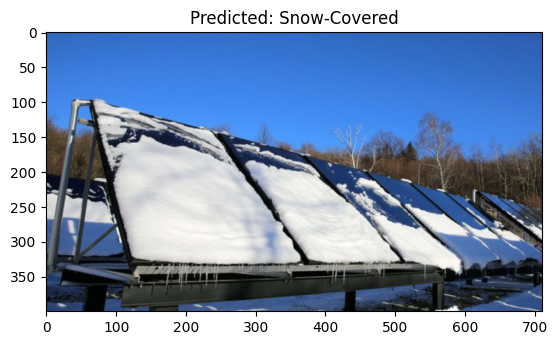

In [17]:
# 9. 새로운 이미지 분류 테스트
def predict_image(image_path, model, transform, device):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # 이미지를 배치 차원 추가 및 텐서 변환

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

# 모델 로드
model.load_state_dict(torch.load('best_model.pth'))

# 테스트할 이미지 경로
test_image_path = '/content/drive/MyDrive/solar panel project/snow_패널.jpg'  # 테스트할 이미지 파일 경로
prediction = predict_image(test_image_path, model, val_transform, device)

# 클래스 이름 확인
class_names = dataset.classes  # 이미지 폴더에서 클래스 이름 가져오기
predicted_class = class_names[prediction]

print(f"Predicted class: {predicted_class}")

# 테스트 이미지 시각화 (선택 사항)
image = Image.open(test_image_path)
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.show()

Predicted class: Bird-drop


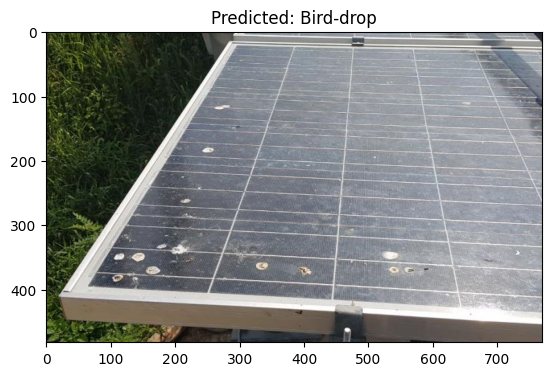

In [18]:
# 테스트할 이미지 경로
test_image_path = '/content/drive/MyDrive/solar panel project/bird poop_패널.jpg'  # 테스트할 이미지 파일 경로
prediction = predict_image(test_image_path, model, val_transform, device)

# 클래스 이름 확인
class_names = dataset.classes  # 이미지 폴더에서 클래스 이름 가져오기
predicted_class = class_names[prediction]

print(f"Predicted class: {predicted_class}")

# 테스트 이미지 시각화 (선택 사항)
image = Image.open(test_image_path)
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.show()